In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

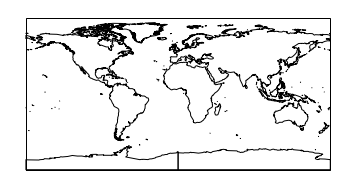

In [2]:
import cartopy.feature as cfeature

ax = plt.axes(projection=ccrs.PlateCarree())

coastline = cfeature.GSHHSFeature(scale='coarse')
c = ax.add_feature(coastline)

In [3]:
extent = [-39, -38.25, -13.25, -12.5]

geoms = list(coastline.intersecting_geometries(extent))

<class 'shapely.geometry.multipolygon.MultiPolygon'>


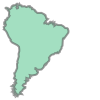

In [4]:
geom = geoms[0]

print(type(geom))

geom

<class 'shapely.geometry.multilinestring.MultiLineString'>


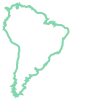

In [5]:
boundary = geom.boundary

print(type(boundary))

boundary

In [6]:
from shapely.ops import linemerge

line = linemerge(boundary)

print(type(line))

x, y = line.xy

<class 'shapely.geometry.linestring.LineString'>


In [7]:
from shapely.geometry import LineString, Point

def cut(line, distance):
    """
    Cuts a line in two at a distance from its starting point.
    
    """
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

In [8]:
def between_points(line, p0, p1):
    dist0 = line.project(p0)
    dist1 = line.project(p1)
    return cut(cut(line, dist0)[0], dist1)[1]

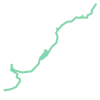

In [9]:
p0 = Point(-60, -40)
p1 = Point(-40,-20)

between_points(line, p0, p1)

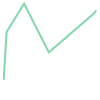

In [10]:
p0 = Point(extent[0], extent[2])
p1 = Point(extent[1], extent[3])

between_points(line, p0, p1)

In [11]:
from shapely.ops import linemerge

coastline = cfeature.GSHHSFeature(scale='high')

geoms = list(coastline.intersecting_geometries(extent))

len(geoms)

67

In [12]:
from shapely.ops import cascaded_union

geom = cascaded_union(geoms)
boundary = geom.boundary

lines = linemerge(boundary)  # Not sure if this causes an artifacts, but it is needed to join lines close together.

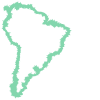

In [13]:
line = lines[0]  # We need to either iterate all the islands or find a better way to cut a `MultiLineString`
line

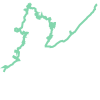

In [14]:
p0 = Point(extent[0], extent[2])
p1 = Point(extent[1], extent[3])

between_points(line, p0, p1)

## Faster approach

In [15]:
import numpy as np
from shapely.ops import linemerge, cascaded_union
from shapely.geometry import MultiPolygon, MultiLineString

def _feature_to_array(cfeature, extent):
    """
    Expect a homogenous list with either MultiPolygon or MultiLineString,
    and extract the longest (first) LineString ignoring island.

    """
    geoms = list(coastline.intersecting_geometries(extent))
    if isinstance(geoms[0], MultiPolygon):
        geom = cascaded_union(geoms).boundary
        # Not sure if this causes an artifacts, but it is needed to join lines close together.
        line = linemerge(geom)[0]
    elif isinstance(geoms[0], MultiLineString):
        line = linemerge(geoms[0])
    else:
        msg = 'Expected a list of `MultiPolygon` or `MultiLineString` but got {}'.format
    return np.array(line.coords)


def knn_search(x, D, K):
    """Find `K` nearest `x` neighbours on `D`."""
    m, n = D.shape
    x = np.atleast_2d(x)
    K = K if K < n else n
    # Euclidean distances from the other points.
    sqd = np.sqrt(((D - x[:n, :])**2).sum(axis=1))
    idx = np.argsort(sqd)
    return idx[K]


def extract_coastline(p0, p1, data):
    idx0 = knn_search(p0, data, 1)
    idx1 = knn_search(p1, data, 1)
    return idx0, idx1

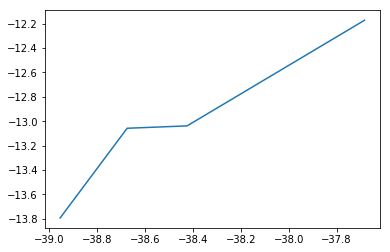

In [16]:
coastline = cfeature.COASTLINE
data = _feature_to_array(coastline, extent=extent)

p0 = extent[0], extent[2]
p1 = extent[1], extent[3]

idx0, idx1 = extract_coastline(p0, p1, data)
lines, = plt.plot(data[idx1:idx0+1, 0], data[idx1:idx0+1, 1])

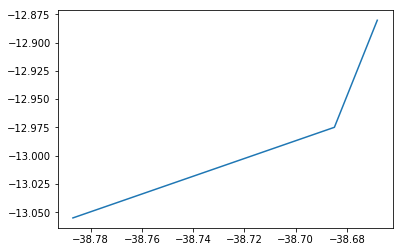

In [17]:
coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m')

data = _feature_to_array(coastline, extent=extent)

p0 = extent[0], extent[2]
p1 = extent[1], extent[3]

idx0, idx1 = extract_coastline(p0, p1, data)
lines, = plt.plot(data[idx1:idx0+1, 0], data[idx1:idx0+1, 1])

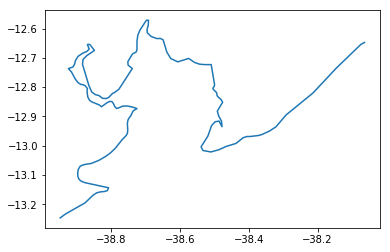

In [18]:
coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '10m')

data = _feature_to_array(coastline, extent=extent)

p0 = extent[0], extent[2]
p1 = extent[1], extent[3]

idx0, idx1 = extract_coastline(p0, p1, data)
lines, = plt.plot(data[idx1:idx0+1, 0], data[idx1:idx0+1, 1])

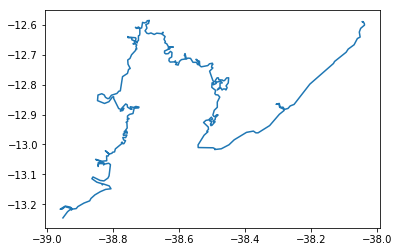

In [19]:
coastline = cfeature.GSHHSFeature(scale='high')
data = _feature_to_array(coastline, extent=extent)

p0 = extent[0], extent[2]
p1 = extent[1], extent[3]

idx0, idx1 = extract_coastline(p0, p1, data)
lines, = plt.plot(data[idx1:idx0+1, 0], data[idx1:idx0+1, 1])